In [1]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
from scipy import stats

In [3]:
#import dataset
fatigue_df = pd.read_csv('../Data/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [4]:
fatigue_df.info()

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

<Axes: >

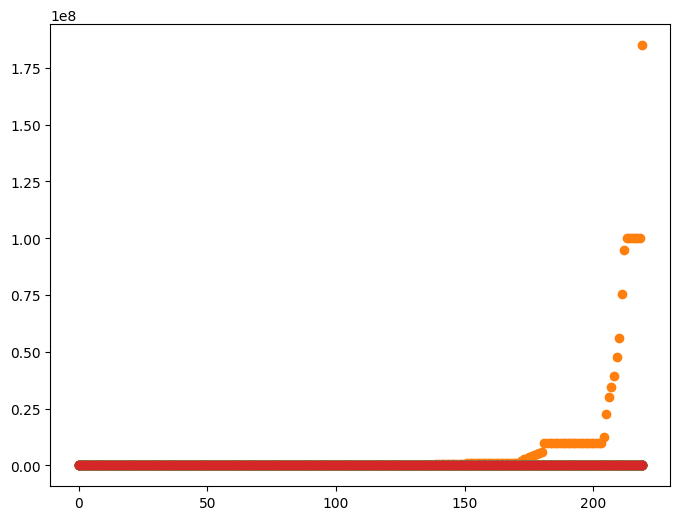

In [5]:
# Scatter Plot of Target Column
fatigue_df.plot(style = 'o', figsize=(8, 6), legend = False)

In [6]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.000,0.004,0.000,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
2,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
3,725.00,1025,2.0,375,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
4,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,253.59,0,0.0,25,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.000,0.000,0.00,18.70,0.000,0.00
216,400.00,0,0.0,600,0,0.0,0.00,0.1,30.0,84.69,...,0.050,0.0025,0.105,0.004,0.009,0.340,4.00,0.69,0.540,3.72
217,282.17,0,0.0,600,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.000,0.000,0.00,18.70,0.000,0.00
218,500.00,0,0.0,25,0,0.0,0.00,-1.0,30.0,84.69,...,0.050,0.0025,0.105,0.004,0.009,0.340,4.00,0.69,0.540,3.72


In [7]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 1
Pearson CC: 0.9513364960654317
R2 score: 0.8997894525527954
RMSE: 0.6275247931480408
MAE: 0.43257027864456177
Coverage: 56.81818181818182
Interval Width: 0.6743979454040527
Composite Metric: 0.7968373743730099


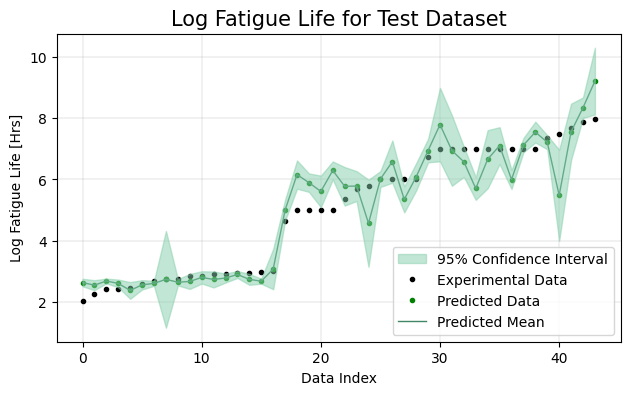

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 2
Pearson CC: 0.9509906114668395
R2 score: 0.8842079639434814
RMSE: 0.6218181252479553
MAE: 0.47621020674705505
Coverage: 93.18181818181817
Interval Width: 2.945331335067749
Composite Metric: 0.7837437301661386


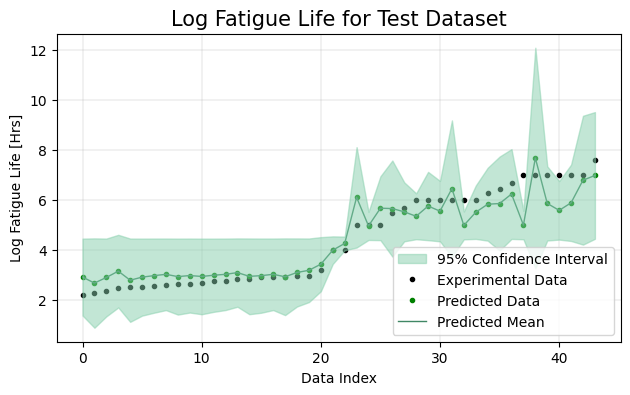

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 3
Pearson CC: 0.9272892917878677
R2 score: 0.8453609943389893
RMSE: 0.7223361730575562
MAE: 0.45035770535469055
Coverage: 54.54545454545455
Interval Width: 0.4498751163482666
Composite Metric: 0.9648006847933395


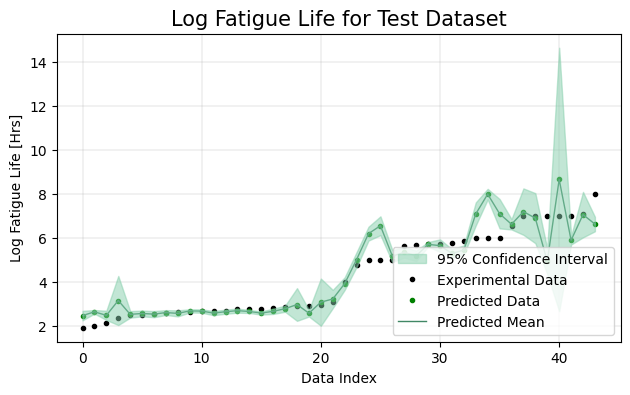

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 4
Pearson CC: 0.9752663211729697
R2 score: 0.9469872713088989
RMSE: 0.4370144009590149
MAE: 0.32439476251602173
Coverage: 59.09090909090909
Interval Width: 0.5335464477539062
Composite Metric: 0.9117445854018716


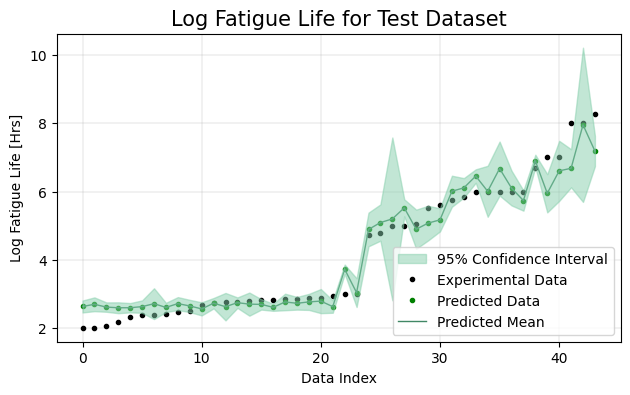

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 5
Pearson CC: 0.9337887384799147
R2 score: 0.8714929819107056
RMSE: 0.6668549180030823
MAE: 0.45960044860839844
Coverage: 50.0
Interval Width: 0.524939775466919
Composite Metric: 0.8512451078842942


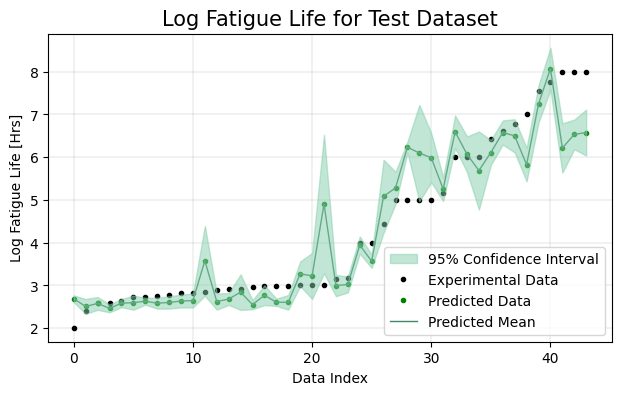

In [8]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
            targets = targets.reset_index(drop=True)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=22, output_dim=1, hidden_dim=100, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.5)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            ensemble_size = 5
            ensemble = [MLP(hidden_dim=10, n_hidden_layers=3) for _ in range(ensemble_size)]

            for net in ensemble:
                  train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_preds = [np.array(net(torch.Tensor(x_test)).clone().detach().numpy()) for net in ensemble]
            # mean and standard deviation
            y_pred = np.mean(np.array(y_preds), axis=0)
            y_std = np.std(np.array(y_preds), axis=0)

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test_np, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test_np, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

In [9]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.951336,0.899789,0.627525,0.432570
1,0.950991,0.884208,0.621818,0.476210
2,0.927289,0.845361,0.722336,0.450358
3,0.975266,0.946987,0.437014,0.324395
4,0.933789,0.871493,0.666855,0.459600


In [10]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.947734,0.016698,0.889568,0.033797,0.61511,0.096013,0.428627,0.053992


In [11]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,56.818182,0.674398,0.796837
1,93.181818,2.945331,0.783744
2,54.545455,0.449875,0.964801
3,59.090909,0.533546,0.911745
4,50.000000,0.524940,0.851245


In [12]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,62.727273,15.521246,1.025618,0.962595,0.861674,0.068597
